In [2]:
!pip install --upgrade pip
!pip install gensim

  Using cached pip-20.2.3-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 24.2 MB 215 kB/s eta 0:00:01    |███▏                            | 2.4 MB 4.0 MB/s eta 0:00:06
     |████████████████████████████████| 122 kB 44.2 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.2.1-py3-none-any.whl size=114113 sha256=7cca0d6c41a12b4fff4d304c7a7125744cfad5c8998f5c275965a55c0ed17c2a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/12/6f/d1/6b06b392acb738f552f25dcfe0aac54a20ec854a20f55240aa
Successfully built smart-open


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src import utils, nmf_utils, nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from collections import Counter
from operator import itemgetter

# NMF - Wall Street Forum

In [4]:
def bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer


In [5]:
def tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer

In [6]:
def print_topics(model, count_vectorizer, n_top_words):
    '''
   
    Args:
    
        
    Return:
    
        
    '''
    
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_words_arr = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join(top_words_arr))

In [7]:
# wsm = Wall Street Market
# append_to_stopwords = ['wsm']

stop_words = stopwords.words("english")# .append(append_to_stopwords)
stopwords_dict = Counter(stop_words)


def tokenize_lemmatize(text):
    '''
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

## Import Dataset and Model Inputs

In [4]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

In [6]:
wallstreet['nmf_tokens'] = wallstreet['processed_text'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))

In [7]:
docs_raw = wallstreet['nmf_tokens']

---
## Use Gensim to Identify Optimal Number of Topics

In [15]:
def create_gensim_dict_corpus(docs_raw, num_below, num_above, num_features):
    '''
    Create corpus to be used to determine optimal number of components using the gensim package.
    
    '''
    gensim_dict = Dictionary(docs_raw)
    gensim_dict.filter_extremes(no_below=num_below, no_above=num_above, keep_n=num_features)
    corpus = [gensim_dict.doc2bow(doc) for doc in docs_raw]
    
    return gensim_dict, corpus


In [16]:
gensim_dict, corpus = create_gensim_dict_corpus(docs_raw, 3, 0.70, 10000)

In [17]:
num_topics_rng = list(np.arange(3, 42 + 1, 3)) 
coherence_scores = []

# NMF MODEL PARAMS
num_passes_over_training_docs = 5
gradient_desc_step = 0.1

# the "normalized" arg must equal true to be relevant.
floor_probs_for_topics = 0.005
normalize = True
num_training_docs_per_chunk = 5000

# W = topics by words
w_max_iter=300
w_stop_condition=0.0001

# H = articles by topics
h_max_iter=100
h_stop_condition=0.001
eval_every=10
random_state = 3

for num in num_topics_rng:
    nmf = Nmf(corpus=corpus, num_topics=num, id2word=gensim_dict, chunksize=num_training_docs_per_chunk,  passes=num_passes_over_training_docs, kappa=gradient_desc_step,
             normalize=normalize, minimum_probability=floor_probs_for_topics, w_max_iter=w_max_iter, w_stop_condition=w_stop_condition, h_max_iter=h_max_iter,
             h_stop_condition=h_stop_condition, eval_every=eval_every, random_state=random_state)
    
    coherence_model = CoherenceModel(model=nmf, texts=docs_raw, dictionary=gensim_dict, coherence='c_v')
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

scores = list(zip(num_topics_rng, coherence_scores))
topics_sorted_by_co_score = sorted(scores, key=itemgetter(1), reverse=True)
print(topics_sorted_by_co_score)

[(6, 0.59677), (21, 0.5887), (15, 0.56236), (12, 0.56207), (30, 0.56167), (24, 0.55983), (39, 0.54707), (9, 0.54517), (27, 0.53694), (3, 0.53544), (42, 0.53417), (36, 0.53037), (18, 0.52463), (33, 0.51486)]


In [18]:
def plot_coherence_scores(num_topics_rng, scores):
    '''
    Visualize coherence scores for their respective number of topics.
    Use to determine optimal number of topics for sklearn NMF model.
    '''
    
    coherence_scores = [scores[i][1] for i in range(len(scores))]

    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(num_topics_rng, coherence_scores, linewidth=3)
    ax.set_title('NMF Model Performance by Number of Topics', fontsize=14)
    ax.set_xlabel('# of Topics')
    ax.set_ylabel('Coherence Score')
    plt.tight_layout();

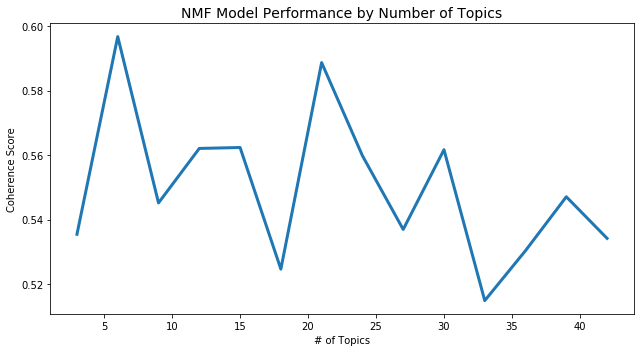

In [19]:
plot_coherence_scores(num_topics_rng, scores)

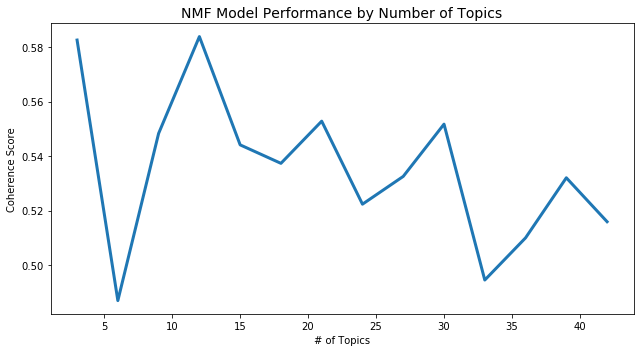

In [98]:
coherence_scores = [scores[i][1] for i in range(len(scores))]

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(num_topics_rng, coherence_scores, linewidth=3)
ax.set_title('NMF Model Performance by Number of Topics', fontsize=14)
ax.set_xlabel('# of Topics')
ax.set_ylabel('Coherence Score')
plt.tight_layout();

---
# NMF Inputs

In [100]:
docs_raw_sklearn = wallstreet['processed_text']

---
# NMF - Bag of Words 

In [101]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 12

bow_vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
bow_docs_vectorized = bow_vectorizer.fit_transform(docs_raw_sklearn)
nmf_bow = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(bow_docs_vectorized)

In [102]:
n_top_words = 10

print_topics(nmf_bow, bow_vectorizer, n_top_words)


Topic #0:
bank one money day link new wsm help market contact good

Topic #1:
like one know time good day money help wsm wsm help

Topic #2:
wsm help rule phished wsm help phished rule help phished link time bank

Topic #3:
account money link know time help bank contact day good

Topic #4:
order day time one good offer wsm wsm help link bank

Topic #5:
market wsm link like wsm help money bank contact day good

Topic #6:
offer link money wsm wsm help market bank contact day good

Topic #7:
vendor good wsm know time like wsm help market bank contact

Topic #8:
wrote know good money help day wsm help bank contact help phished

Topic #9:
need help money time know one market bank contact day

Topic #10:
contact link rule time wsm help market bank day good help

Topic #11:
new link help one time wsm help market bank contact day


---
## NMF - Tf-Idf

In [108]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 12

tfidf_vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
tfidf_docs_vectorized = tfidf_vectorizer.fit_transform(docs_raw_sklearn)
nmf_tfidf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(tfidf_docs_vectorized)

In [109]:
n_top_words = 10

print_topics(nmf_tfidf, tfidf_vectorizer, n_top_words)


Topic #0:
offer link contact new money rule bank time wsm help day

Topic #1:
help wsm rule phished phished rule help phished wsm help contact link time

Topic #2:
market wsm time new link wsm help bank contact day good

Topic #3:
vendor time one new contact day account link bank good

Topic #4:
wrote contact time one help money market wsm help link bank

Topic #5:
bank one day money time new help market wsm help link

Topic #6:
order time day new wsm one help money wsm help like

Topic #7:
need money help time new contact market bank day good

Topic #8:
good time day money new one help wsm help link bank

Topic #9:
know time one help money new wsm help link bank contact

Topic #10:
account bank money new link market contact day good help

Topic #11:
like time money one new help day wsm help link bank


### Evaluate nmf_tfidf Model Performance
Calculate the residuals

In [110]:
A = tfidf_docs_vectorized
W = nmf_tfidf.components_
H = nmf_tfidf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 45372 x 25
W = 12 x 25
H = 45372 x 12


In [112]:
residuals = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    residuals[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), ord='fro')

sum_sqrt_resids = round(sum(np.sqrt(residuals)), 3)
print('Sum of the squared residuals: ', sum_sqrt_resids)

Sum of the squared residuals:  22848.651
